In [48]:
#kütüphanelerin yüklenmesi
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from statistics import mean, median, mode, stdev
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder


In [49]:
#görünümü daha iyi hale getirmek için bazı ayarlar 
warnings.simplefilter(action='ignore', category=Warning)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 300)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [50]:
#veriyi okuma
df = pd.read_csv("/kaggle/input/global-air-pollution-dataset/global air pollution dataset.csv")

In [51]:
#öncelikle veriyi tanımak için bir fonksiyon yazalım

def check_data(df,n=5):
    #sayısal değişkenlere genel bakış
    print("sayısal değişkenlere genel bakış")
    print("*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n")
    print(df.describe().T)
    print("\n\n")
    
    # boyut bilgisi
    print("boyut bilgisi")
    print("*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n")
    print(df.shape)
    print("\n\n")
    
    # Verinin ilk beş satırını görüntüle
    print("ilk",n,"satır")
    print("*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n")
    print(df.head(n))
    print("\n\n")
    
    #Verinin son beş satırını görüntüle
    print("son",n,"satır")
    print("*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n")
    print(df.tail(n))
    print("\n\n")
    
    # Veri hakkında bilgi görüntüle
    print("veriye genel bakış")
    print("*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n")
    print(df.info())
    print("\n\n")
    
    # Sütun tiplerini görüntüle
    print("sütun tipleri neler")
    print("*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n")
    print(df.dtypes)
    print("\n\n")
    
    # Eksik verileri say
    print("eksik verilere genel bakış")
    print("*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n")
    print(df.isnull().sum())

In [52]:
check_data(df)

sayısal değişkenlere genel bakış
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

                      count     mean      std     min      25%      50%      75%       max
AQI Value       23463.00000 72.01087 56.05522 6.00000 39.00000 55.00000 79.00000 500.00000
CO AQI Value    23463.00000  1.36837  1.83206 0.00000  1.00000  1.00000  1.00000 133.00000
Ozone AQI Value 23463.00000 35.19371 28.09872 0.00000 21.00000 31.00000 40.00000 235.00000
NO2 AQI Value   23463.00000  3.06333  5.25411 0.00000  0.00000  1.00000  4.00000  91.00000
PM2.5 AQI Value 23463.00000 68.51975 54.79644 0.00000 35.00000 54.00000 79.00000 500.00000



boyut bilgisi
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

(23463, 12)



ilk 5 satır
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

              Country              City  AQI Value AQI Category  CO AQI Value CO AQI Category  Ozone AQI Value Ozone AQI Category  NO2 AQI Value NO2 AQI Category  PM2.5 AQI Value PM2.5 AQI Category
0  Russian Federation        Praskoveya         51     Moderat

In [53]:
#verimizdeki eksik değerlerin oranına bakalım

def missing_values_percentage(df):
    #eksik değer barındıran sütunları listeye ekleyelim
    mis_val_col = []
    for column in df.columns:
      if df[column].isnull().any():
        mis_val_col.append(column)
    
    #eğer boş küme dönerse eksik veri olmadığını ekrana bastıralım
    if len(mis_val_col) == 0:
        print("verinizde eksik değer bulunmuyor")

    #eksik verilerin sütundaki toplam veri sayısına oranını ekrana bastıralım 
    for col in mis_val_col:
        total_values = df[col].count()
        missing_values = df[col].isnull().sum()
        percentage = (missing_values/total_values) * 100
        print(f"{col} sütununda {percentage:.3f}% eksik değer var \n")
        

In [54]:
missing_values_percentage(df)

Country sütununda 1.854% eksik değer var 

City sütununda 0.004% eksik değer var 



In [55]:
#buna göre eksik değerlerin oranı çok ciddiye alınabilir değil. bu yüzden silme yöntemiyle veriyi eksik değerlerden kurtaralım

In [56]:
df = df.dropna()

In [57]:
missing_values_percentage(df)

verinizde eksik değer bulunmuyor


In [58]:
#şimdi gözle aykırı değerlere bakmak için kutu grafikleri oluşturalım 
#bunun için önceklikle değişkenlerimizi numerik kategorik olarak ayıralım. 
#daha fonksiyonel olması için numerik gibi görünen kategorik değişkenler olma ihtimalini de gözetelim. 

In [59]:
def separate_variables(df,treshold=10):
    numeric_vars = []
    categorical_vars = []
    categorical_like_vars = []
    
    for col in df.columns:
        if df[col].dtype == 'float64' or df[col].dtype == 'int64':
            numeric_vars.append(col)
        elif len(df[col].unique()) < treshold: 
            categorical_like_vars.append(col)
        else:
            categorical_vars.append(col)
    
    print("Numerik değişkenler:{} \nKategorik değişkenler{} \nNumerik görünümlü kategorik değişkenler {}".format(numeric_vars, categorical_vars,categorical_like_vars))
    return numeric_vars, categorical_vars, categorical_like_vars


In [60]:
numeric_vars, categorical_vars, categorical_like_vars = separate_variables(df)

Numerik değişkenler:['AQI Value', 'CO AQI Value', 'Ozone AQI Value', 'NO2 AQI Value', 'PM2.5 AQI Value'] 
Kategorik değişkenler['Country', 'City'] 
Numerik görünümlü kategorik değişkenler ['AQI Category', 'CO AQI Category', 'Ozone AQI Category', 'NO2 AQI Category', 'PM2.5 AQI Category']


In [61]:
#numerik değişkenlerin aykırı değerlerini grafik üzerinde görelim 

In [62]:
def detect_outliers(df, variable):
    sns.boxplot(x=df[variable])
    plt.show()

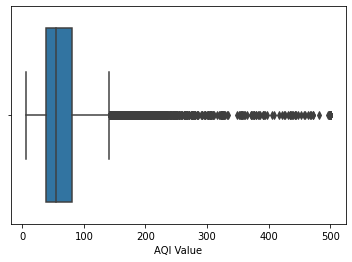

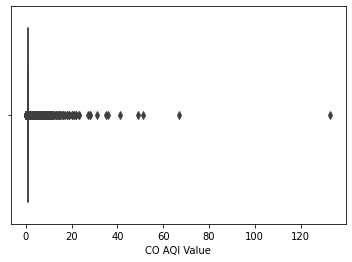

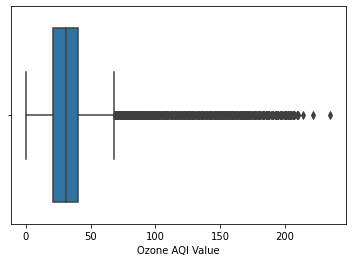

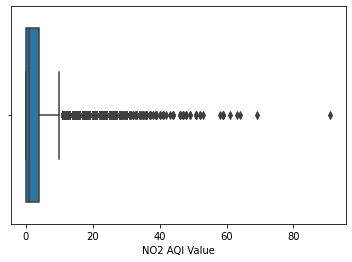

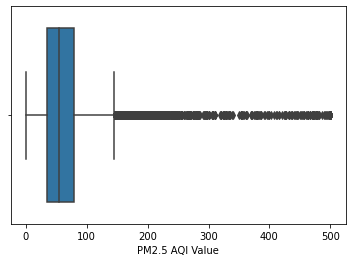

In [63]:
for col in numeric_vars:
    detect_outliers(df,col)

In [64]:
#verimizde varsayılan eşik değerlere göre aykırı değer sayılabilecek çok sayıda değişken görünüyor
#bunları doğrudan aykırı değer olarak değerlendirmenin doğru olmadığını düşünüyoruz. 
#bu yüzden verinin üçte birinci (Q1) ve üçte üçüncü (Q3) kuartil değerlerini kendimiz hesapladığımız bir fonksiyon yazalım

In [65]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [66]:
#buna göre aykırı değerleri tekrar gözden geçirelim. 

In [67]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True    
    else:
        return False
        

In [68]:
def grab_outliers(dataframe, col_name):
    low, up = outlier_thresholds(dataframe, col_name)
    outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
    return outlier_index

In [69]:
for col in numeric_vars:
    outlier_index = grab_outliers(df,col) 
    percentage_outliers =  len(outlier_index)/len(df[col])* 100
    print(f"{col} sütununda;\n{len(outlier_index)} adet aykırı değerli örneklem vardır (%{percentage_outliers:.3f})\n")

AQI Value sütununda;
132 adet aykırı değerli örneklem vardır (%0.573)

CO AQI Value sütununda;
93 adet aykırı değerli örneklem vardır (%0.404)

Ozone AQI Value sütununda;
33 adet aykırı değerli örneklem vardır (%0.143)

NO2 AQI Value sütununda;
105 adet aykırı değerli örneklem vardır (%0.456)

PM2.5 AQI Value sütununda;
99 adet aykırı değerli örneklem vardır (%0.430)



In [70]:
#q1 = 0.05 ve q3 = 0.95 değerleriyle elde ettiğimiz aykırılıkların silinmesi yaklaşımını uygulayalım 


In [71]:
#numerik sütunları döngü içerisinde aykırı değerlerinden arındıralım. 
for col in numeric_vars:
    low_limit, up_limit = outlier_thresholds(df, col)
    df = df[~((df[col] < low_limit) | (df[col] > up_limit))]
    

In [72]:
#son haliyle verimizin boyutuna bakalım 
df.shape

(22702, 12)

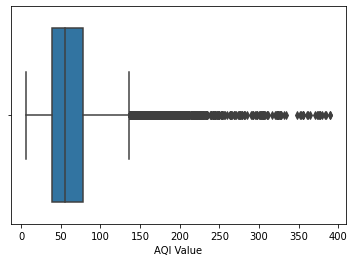

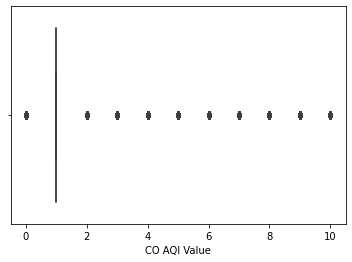

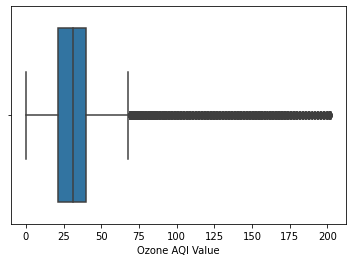

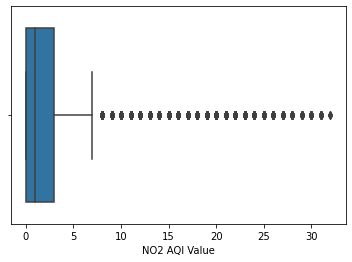

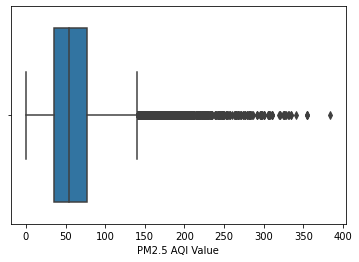

In [73]:
#yeniden kutu grafiklerini gözlemleyelim
for col in numeric_vars:
    detect_outliers(df,col)

In [74]:
#bu sonuçlara göre, CO2 AQI value değerlerinin benzer özellikte bir kısmının aykırı değer olarak değerlendirildiğini tespit ettik 
#bu verinin içerdiği anlamı kaybetmesine sebep olabilir.
#emin olmak için veri içerisinde barınan her numerik değişkene karşılık gelen kategorik değişkenlerin de kutu grafiğini çizdirelim.


In [75]:
def plot_boxplot(dataframe, num_col, cat_col):
    sns.boxplot(x=cat_col, y=num_col, data=dataframe)
    sns.despine()
    plt.gcf().set_size_inches(15, 7)
    plt.title("{} sayısal değişkeninin {} kategorilerine göre dağılımı".format(num_col, cat_col))
    plt.show()

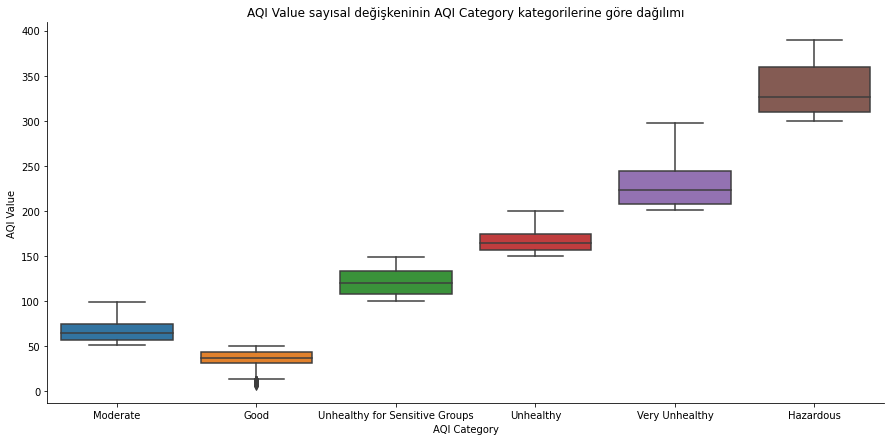

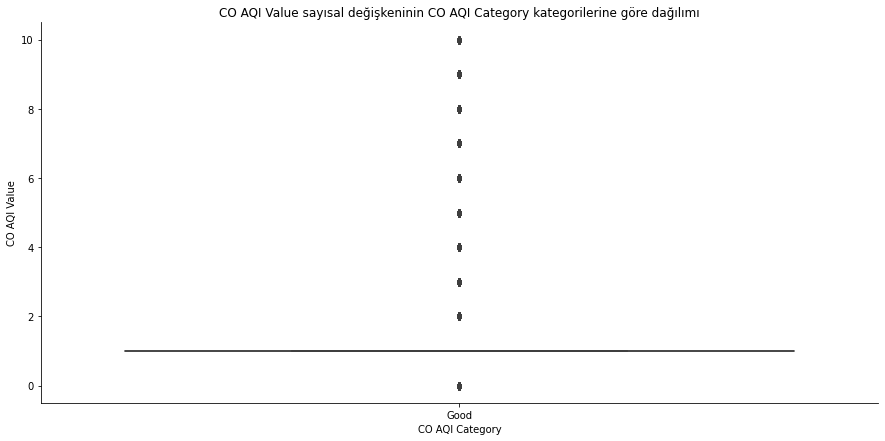

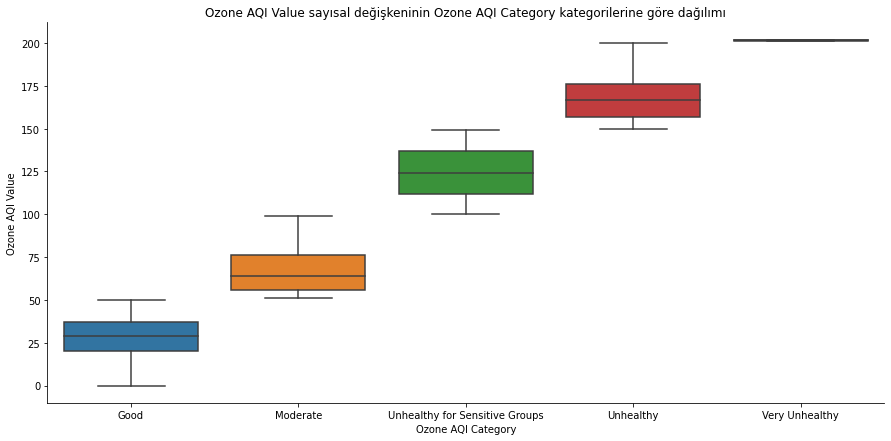

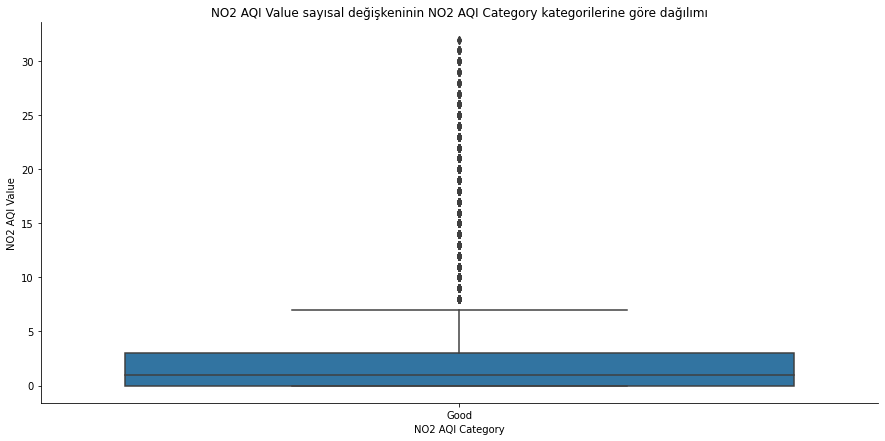

In [76]:
plot_boxplot(df,"AQI Value", "AQI Category")
print("\n\n")
plot_boxplot(df,"CO AQI Value", "CO AQI Category")
print("\n\n")
plot_boxplot(df,"Ozone AQI Value", "Ozone AQI Category")
print("\n\n")
plot_boxplot(df,"NO2 AQI Value", "NO2 AQI Category")

In [77]:
#tahmin ettiğimiz gibi CO2 AQI değişkeninde bozulmaya neden olmuşuz. başlangıçta 3 kategorisi bulunan CO2 value değeri normal dağılıma 
#sahip olmadığı için, q1,q3 eşikleri anlamlı verileri kaybetmemize de sebep oldu. 
#bunu istemediğimizden verimizde aykırı değerlere yönelik işlem yapmamayı tercih ediyoruz. 

In [78]:
#veriyi tekrar yükleyip eksik değerlerden kurtulalım.
df = pd.read_csv("/kaggle/input/global-air-pollution-dataset/global air pollution dataset.csv")
df = df.dropna()

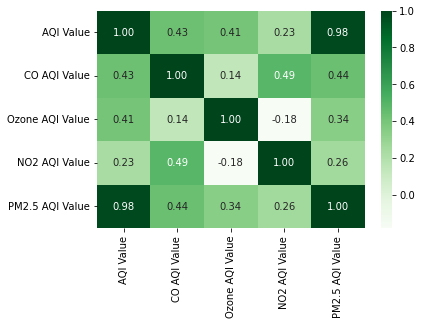

In [79]:
#korelasyon matrisine bakalım
sns.heatmap(df.corr(),annot=True, cbar=True, cmap='Greens', fmt='.2f');

In [80]:
"""
tablomuza göre yüksek korelasyonlu 2 değişkenimiz var.
"""

'\ntablomuza göre yüksek korelasyonlu 2 değişkenimiz var.\n'

In [81]:
#eşsiz değerlere bakmak için bir fonksiyon yazalım (yalnızca object tipinde )
def count_unique_values(df):
    for col in df.columns:
        if df[col].dtype == object:
            print(f"{col} sütununda {df[col].nunique()} eşsiz değer var \n")

In [82]:
count_unique_values(df)

Country sütununda 175 eşsiz değer var 

City sütununda 23035 eşsiz değer var 

AQI Category sütununda 6 eşsiz değer var 

CO AQI Category sütununda 3 eşsiz değer var 

Ozone AQI Category sütununda 5 eşsiz değer var 

NO2 AQI Category sütununda 2 eşsiz değer var 

PM2.5 AQI Category sütununda 6 eşsiz değer var 



In [83]:
#buna göre kategorik değişkenleri kuracağımız modellerin anlayabilmesi için encoding işlemlerinden geçirelim 

In [84]:

#one hot encoder nesnemizi oluşturalım
one_hot_encoder = OneHotEncoder()
#ohe yapacağımız fonksiyonu yazalım 
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe


In [85]:
#ohe uygulayacağımız kategorik değişkenleri filtreleyelim 
cate_cols = [col for col in df.columns if 10 >= df[col].nunique() > 1]

cate_cols

['AQI Category',
 'CO AQI Category',
 'Ozone AQI Category',
 'NO2 AQI Category',
 'PM2.5 AQI Category']

In [86]:
#beklediğimiz değişkenleri aldık şimdi ohe fonksiyonumuza bunları gönderelim ve yeni df olarak kaydedelim
#dummy değişken tuzağına düşmemek için fonksiyonumuzda varsayılan False argümanını True olarak gönderdik
df_last = one_hot_encoder(df, cate_cols,True)

pd.set_option('display.max_columns', 30)
df_last.head()

,Country,City,AQI Value,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value,AQI Category_Hazardous,AQI Category_Moderate,AQI Category_Unhealthy,AQI Category_Unhealthy for Sensitive Groups,AQI Category_Very Unhealthy,CO AQI Category_Moderate,CO AQI Category_Unhealthy for Sensitive Groups,Ozone AQI Category_Moderate,Ozone AQI Category_Unhealthy,Ozone AQI Category_Unhealthy for Sensitive Groups,Ozone AQI Category_Very Unhealthy,NO2 AQI Category_Moderate,PM2.5 AQI Category_Hazardous,PM2.5 AQI Category_Moderate,PM2.5 AQI Category_Unhealthy,PM2.5 AQI Category_Unhealthy for Sensitive Groups,PM2.5 AQI Category_Very Unhealthy
0,Russian Federation,Praskoveya,51,1,36,0,51,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,Brazil,Presidente Dutra,41,1,5,1,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Italy,Priolo Gargallo,66,1,39,2,66,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,Poland,Przasnysz,34,1,34,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,France,Punaauia,22,0,22,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [87]:
#sayısal değişkenlerin tahmini için lineer regresyon modeli 
"""
* verimizdeki uniqie değerleri modele dahil etmeyeceğiz. 
* kategorileri OHE ederek, 
* diğerlerini standartlaştırarak modelimizi kuralım 

"""

'\n* verimizdeki uniqie değerleri modele dahil etmeyeceğiz. \n* kategorileri OHE ederek, \n* diğerlerini standartlaştırarak modelimizi kuralım \n\n'

In [88]:
df_last.head()

,Country,City,AQI Value,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value,AQI Category_Hazardous,AQI Category_Moderate,AQI Category_Unhealthy,AQI Category_Unhealthy for Sensitive Groups,AQI Category_Very Unhealthy,CO AQI Category_Moderate,CO AQI Category_Unhealthy for Sensitive Groups,Ozone AQI Category_Moderate,Ozone AQI Category_Unhealthy,Ozone AQI Category_Unhealthy for Sensitive Groups,Ozone AQI Category_Very Unhealthy,NO2 AQI Category_Moderate,PM2.5 AQI Category_Hazardous,PM2.5 AQI Category_Moderate,PM2.5 AQI Category_Unhealthy,PM2.5 AQI Category_Unhealthy for Sensitive Groups,PM2.5 AQI Category_Very Unhealthy
0,Russian Federation,Praskoveya,51,1,36,0,51,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,Brazil,Presidente Dutra,41,1,5,1,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Italy,Priolo Gargallo,66,1,39,2,66,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,Poland,Przasnysz,34,1,34,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,France,Punaauia,22,0,22,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [89]:
#bağımlı değişkenimizi NO2 AQI Value olarak seçtik 
#bir anlam içermeyen city, country değişkenlerini, bağımlı değişkenimizi ve doğrudan bağımlı değişkenden çıkarılan category değişkenimizi çıkarmak için listeye alalım 

drop_list = ["Country","City","NO2 AQI Value","NO2 AQI Category_Moderate"]

In [90]:
X = df_last.drop(drop_list, axis=1)
y = df_last[["NO2 AQI Value"]]


In [91]:
#son haliyle modelimiz kurulmaya hazır. 
X.head()

,AQI Value,CO AQI Value,Ozone AQI Value,PM2.5 AQI Value,AQI Category_Hazardous,AQI Category_Moderate,AQI Category_Unhealthy,AQI Category_Unhealthy for Sensitive Groups,AQI Category_Very Unhealthy,CO AQI Category_Moderate,CO AQI Category_Unhealthy for Sensitive Groups,Ozone AQI Category_Moderate,Ozone AQI Category_Unhealthy,Ozone AQI Category_Unhealthy for Sensitive Groups,Ozone AQI Category_Very Unhealthy,PM2.5 AQI Category_Hazardous,PM2.5 AQI Category_Moderate,PM2.5 AQI Category_Unhealthy,PM2.5 AQI Category_Unhealthy for Sensitive Groups,PM2.5 AQI Category_Very Unhealthy
0,51,1,36,51,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,41,1,5,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,66,1,39,66,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,34,1,34,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,22,0,22,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [92]:
y.head()

,NO2 AQI Value
0,0
1,1
2,2
3,0
4,0


In [93]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=1)

In [94]:
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

LinearRegression()

In [95]:
y_pred = reg_model.predict(X_train)

In [96]:
y_pred = reg_model.predict(X_train)
r2 = reg_model.score(X_test, y_test)

In [97]:
"""reg_model = LinearRegression(fit_intercept=True,normalize=False)
reg_model.fit(X_train, y_train)"""

'reg_model = LinearRegression(fit_intercept=True,normalize=False)\nreg_model.fit(X_train, y_train)'

In [98]:
r2 

0.10806252979602471

r2 değerimiz oldukça düşük çıktı. 
burada geriye dönüp baktığımızda bunun olası nedenleri;
* 1- aykırı değerler üzerine yeteri kadar çalışmamamız, 
* 2- verinin içerdiği özelliklerin yetersiz olması 
* 3- hiperparametre optimizasyonu yapılmaması 
* 4- iş bilgisinin yeteri kadar olmamasından doğan veri önişleme adımındaki yetersiz yaklaşımlar olabilir

modelimizi bir de uzaklık temelli ağaç yöntemlerinde kurmayı deneyelim

In [99]:
#uzaklık temelli ağaç yöntemleri kullanmadan önce sayısal değişkenlerimizi standartlaştıralım

In [102]:
#scale nesnemizi oluşturalım
scaler = StandardScaler()

#numerik değişkenlerimizi standartlaştıralım
df_last[numeric_vars] = scaler.fit_transform(df_last[numeric_vars])

In [103]:
df_last.head()

,Country,City,AQI Value,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value,AQI Category_Hazardous,AQI Category_Moderate,AQI Category_Unhealthy,AQI Category_Unhealthy for Sensitive Groups,AQI Category_Very Unhealthy,CO AQI Category_Moderate,CO AQI Category_Unhealthy for Sensitive Groups,Ozone AQI Category_Moderate,Ozone AQI Category_Unhealthy,Ozone AQI Category_Unhealthy for Sensitive Groups,Ozone AQI Category_Very Unhealthy,NO2 AQI Category_Moderate,PM2.5 AQI Category_Hazardous,PM2.5 AQI Category_Moderate,PM2.5 AQI Category_Unhealthy,PM2.5 AQI Category_Unhealthy for Sensitive Groups,PM2.5 AQI Category_Very Unhealthy
0,Russian Federation,Praskoveya,-0.37872,-0.20394,0.02713,-0.58405,-0.32482,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,Brazil,Presidente Dutra,-0.55615,-0.20394,-1.07076,-0.39472,-0.50645,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Italy,Priolo Gargallo,-0.11257,-0.20394,0.13338,-0.20538,-0.05237,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,Poland,Przasnysz,-0.68036,-0.20394,-0.04370,-0.58405,-0.88788,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,France,Punaauia,-0.89327,-0.74598,-0.46869,-0.58405,-1.14217,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [104]:
import statsmodels.api as sm

In [105]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
r_dt = DecisionTreeRegressor(random_state=0)
r_dt.fit(X,y)
model4 = sm.OLS(r_dt.predict(X),X)
print(model4.fit().summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.630
Model:                            OLS   Adj. R-squared (uncentered):              0.630
Method:                 Least Squares   F-statistic:                              1959.
Date:                Thu, 05 Jan 2023   Prob (F-statistic):                        0.00
Time:                        20:59:48   Log-Likelihood:                         -61725.
No. Observations:               23035   AIC:                                  1.235e+05
Df Residuals:                   23015   BIC:                                  1.237e+05
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--

In [106]:
print("Decision Tree R2 degeri:")
print(r2_score(y_test, r_dt.predict(X_test)) )


Decision Tree R2 degeri:
0.8547832263414987


Daha iyi bir sonuç elde ettik. bunu hiperparametre optimizasyonuyla arttırmayı hedefleyelim

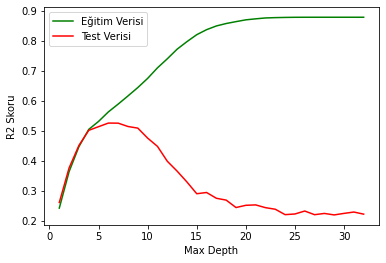

In [107]:
# model karmaşıklığını max_depths parametresiyle arttırarak hiperparametre optimizasyonu yapalım
max_depths = np.linspace(1, 32, 32, endpoint=True)


train_results = []
test_results = []
for max_depth in max_depths:
    dt = DecisionTreeRegressor(max_depth=max_depth)
    dt.fit(X_train, y_train)

    #r2 değerlerini eğitim ve test veri için listeye ekleyelim
    train_pred = dt.predict(X_train)
    train_r2 = r2_score(y_train, train_pred)
    train_results.append(train_r2)

    
    test_pred = dt.predict(X_test)
    test_r2 = r2_score(y_test, test_pred)
    test_results.append(test_r2)

#train ve test r2 sonuclarını grafik ile görekek optimum max_depth değerini elde edelim. 
plt.plot(max_depths, train_results, 'g', label='Eğitim Verisi')
plt.plot(max_depths, test_results, 'r', label='Test Verisi')
plt.ylabel('R2 Skoru')
plt.xlabel('Max Depth')
plt.legend()
plt.show()


In [108]:
#grafikte gördüğümüz kadarıyla max_depth = 5 değerinden itibaren modelimiz eğitim setini ezberlemeye başlamış. 
#max_depth için en uygun değeri 5 olarak seçebiliriz

In [109]:
""" TODO
* diğer parametreler için de hiperparametre optimizasyonu yapılabilir
* k katlı çapraz doğrulama yapılabilir
* görselleştirmeleri ve iş analizi kısımlarını arttır 
* problem tanımını iyileştir 





"""

' TODO\n* diğer parametreler için de hiperparametre optimizasyonu yapılabilir\n* k katlı çapraz doğrulama yapılabilir\n* görselleştirmeleri ve iş analizi kısımlarını arttır \n* problem tanımını iyileştir \n\nTo be continued \n\n\n\n'

# To be continued 